# NN (Neural Network) Starter for Used Car Comp
This notebook shows how to make a simple NN for Kaggle's playground used car regression competition. It uses embedding layers for categorical features and standardizes numerical features. This notebook achieves `CV=72800` and `LB=72300` without any feature engineering nor external data! Discussion [here][1]

We can improve the CV score and LB score by:
* engineering more features 
* try different preprocess
* use more train data and/or data augmentation
* modify NN architecture
* adjust learning rate and schedules
* modify optimizers and loss function
* post process

**UPDATE** Version 2 fixes typo in Code cell #4 discovered by ScriptChef [here][2]. After standardizing numerical feature(s) to `mean=0` and `std=1`, we need to `fillna()` with `zero`, not `mean`. (This typo didn't affect version 1 `submission.csv` nor CV score because numerical feature `milage` didn't have any NAN, but if we engineer more numerical features, it is good to do this correctly).

[1]: https://www.kaggle.com/competitions/playground-series-s4e9/discussion/532965
[2]: https://www.kaggle.com/competitions/playground-series-s4e9/discussion/532965#2989439

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1" 

VER=1

# Load Train and Test

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/playground-series-s4e9/train.csv") 
print("Train shape:", train.shape )
TRAIN_LN = len(train)
display( train.head(1) )

test = pd.read_csv("/kaggle/input/playground-series-s4e9/test.csv") 
test['price'] = 0
print("Test shape:", test.shape )
display( test.head(1) )

train = pd.concat([train,test],axis=0,ignore_index=True)
print("Combined shape:", train.shape )

Train shape: (188533, 13)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200


Test shape: (125690, 13)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes,0


Combined shape: (314223, 13)


# Preprocess
We process categorical and numerical features of train and test data combined.

For categoricals, we use label encoder and label all rare values as `label=0` and NAN as `label=1`. (Pandas factorize transforms NAN into -1 then we add 1, then we add 1). We define a rare value as `samples < 40`. We label all unseen test values as `label=0` too (because these values have no train samples to train the embedding).

For numerical features, we standardize them because NN like numerical to have `mean=0` and `std=1`.

In [3]:
CATS = [c for c in train.columns if not c in ["id","price"] ]
NUMS = ['milage']
CATS = [c for c in CATS if not c in NUMS]
print("Categorical features:", CATS )
print("Numerical features:", NUMS)

Categorical features: ['brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Numerical features: ['milage']


In [4]:
# STANDARIZE NUMERICAL FEATURES
print("STANDARDIZING: ",end="")
for c in NUMS:
    print(c,', ',end='')
    m = train[c].mean()
    s = train[c].std()
    train[c] = (train[c]-m)/s
    train[c] = train[c].fillna(0)

STANDARDIZING: milage , 

In [5]:
# LABEL ENCODE CATEGORICAL FEATURES
CAT_SIZE = []
CAT_EMB = []
RARE = []

print("LABEL ENCODING:")
for c in CATS:
    # LABEL ENCODE
    train[c],_ = train[c].factorize()
    train[c] -= train[c].min()
    vc = train[c].value_counts()
    
    # IDENTIFY RARE VALUES
    RARE.append( vc.loc[vc<40].index.values )
    n = train[c].nunique()
    mn = train[c].min()
    mx = train[c].max()
    r = len(RARE[-1])
    print(f'{c}: nunique={n}, min={mn}, max={mx}, rare_ct={r}')
    
    # RELABEL RARE VALUES AS ZERO
    CAT_SIZE.append(mx+1 +1) #ADD ONE FOR RARE
    CAT_EMB.append( int(np.ceil( np.sqrt(mx+1 +1))) ) # ADD ONE FOR RARE
    train[c] += 1
    train.loc[train[c].isin(RARE[-1]),c] = 0 

LABEL ENCODING:
brand: nunique=57, min=0, max=56, rare_ct=8
model: nunique=1898, min=0, max=1897, rare_ct=551
model_year: nunique=36, min=0, max=35, rare_ct=4
fuel_type: nunique=8, min=0, max=7, rare_ct=1
engine: nunique=1118, min=0, max=1117, rare_ct=308
transmission: nunique=52, min=0, max=51, rare_ct=8
ext_col: nunique=319, min=0, max=318, rare_ct=99
int_col: nunique=156, min=0, max=155, rare_ct=48
accident: nunique=3, min=0, max=2, rare_ct=0
clean_title: nunique=2, min=0, max=1, rare_ct=0


# EDA Test Data vs. Train Data

In [6]:
test = train.iloc[TRAIN_LN:]
train = train.iloc[:TRAIN_LN]
train.shape, test.shape

((188533, 13), (125690, 13))

In [7]:
for c in CATS:
    # COMPARE TEST CAT VALUES TO TRAIN CAT VALUES
    A = train[c].unique()
    B = test[c].unique()
    C = np.setdiff1d(B,A)
    print(f"{c}: Test has label encodes = {C} which are not in train.")
    if len(C)>0:
        print(f" => {len(test.loc[test[c].isin(C)])} rows" )
        
    # RELABEL UNSEEN TEST VALUES AS ZERO
    test.loc[test[c].isin(C),c] = 0 

brand: Test has label encodes = [] which are not in train.
model: Test has label encodes = [1898] which are not in train.
 => 1 rows
model_year: Test has label encodes = [36] which are not in train.
 => 1 rows
fuel_type: Test has label encodes = [] which are not in train.
engine: Test has label encodes = [1118] which are not in train.
 => 4 rows
transmission: Test has label encodes = [] which are not in train.
ext_col: Test has label encodes = [] which are not in train.
int_col: Test has label encodes = [] which are not in train.
accident: Test has label encodes = [] which are not in train.
clean_title: Test has label encodes = [] which are not in train.


# NN Model

In [8]:
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding
from tensorflow.keras.layers import Concatenate, Multiply
import tensorflow.keras.backend as K

print('TF Version',tf.__version__)

TF Version 2.16.1


# Learning Schedule
We use simple learning schedule. We train `2 epochs` with Adam `LR=1e-3` then `1 more epoch` with Adam `LR=1e-4`.

Learning rate schedule: 0.001 to 0.001 to 0.0001


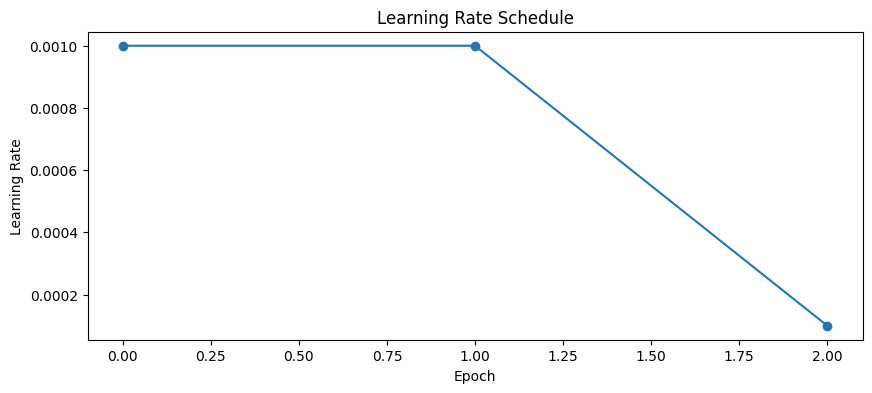

In [9]:
EPOCHS = 3
LRS = [0.001]*2 + [0.0001]*1

def lrfn(epoch):
    return LRS[epoch]

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
        format(lr_y[0], max(lr_y), lr_y[-1]))
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

# Build NN Model
We use simple architecture. We label encode categoricals then concatenate that with numericals. Then we use 3 hidden layers. Finally we output 1 regression. We will use MSE loss and RMSE metric.

In [10]:
def build_model():
    
    # CATEGORICAL FEATURES
    x_input_cats = Input(shape=(len(CATS),))
    embs = []
    for j in range(len(CATS)):
        e = tf.keras.layers.Embedding(CAT_SIZE[j],CAT_EMB[j])
        x = e(x_input_cats[:,j])
        x = tf.keras.layers.Flatten()(x)
        embs.append(x)
        
    # NUMERICAL FEATURES
    x_input_nums = Input(shape=(len(NUMS),))
    
    # COMBINE
    x = tf.keras.layers.Concatenate(axis=-1)(embs+[x_input_nums]) 
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    
    return model

# Train KFold
We train with KFold and save OOF to disk. We can use them later for finding ensemble weights with other models.

In [11]:
FOLDS = 5
kf = KFold(n_splits=FOLDS, random_state=42, shuffle=True)

oof = np.zeros( len(train) )
pred = np.zeros( len(test) )

directory = "checkpoints"
if not os.path.exists(directory):
    os.makedirs(directory)

for i, (train_index, test_index) in enumerate(kf.split(train)):

    
    X_train_cats = train.loc[train_index,CATS].values
    X_train_nums = train.loc[train_index,NUMS].values
    y_train = train.loc[train_index,"price"].values
    
    X_valid_cats = train.loc[test_index,CATS].values
    X_valid_nums = train.loc[test_index,NUMS].values
    y_valid = train.loc[test_index,"price"].values
    
    X_test_cats = test[CATS].values
    X_test_nums = test[NUMS].values
    
    print("#"*25)
    print(f"### Fold {i+1} ###")
    print("#"*25)
    
    # TRAIN MODEL
    K.clear_session()
    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
                  loss="mean_squared_error", 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    model.fit([X_train_cats,X_train_nums], y_train, 
              validation_data = ([X_valid_cats,X_valid_nums], y_valid),
              callbacks = [lr_callback],
              batch_size=64, epochs=EPOCHS, verbose=2)
    model.save_weights(f'{directory}/NN_v{VER}_f{i}.weights.h5')
    
    # OOF PREDS
    oof_preds = model.predict([X_valid_cats,X_valid_nums], verbose=1, batch_size=512).flatten()
    rsme = np.sqrt(np.mean( (oof_preds-y_valid)**2 ))
    print(' => RSME =',rsme,'\n')
    if i<FOLDS: oof[test_index] = oof_preds
    else: oof[test_index] += oof_preds
        
    # TEST PREDS
    test_preds = model.predict([X_test_cats,X_test_nums], verbose=1, batch_size=512).flatten()
    if i==0: pred = test_preds
    else: pred += test_preds
    
pred /= FOLDS

#########################
### Fold 1 ###
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/3


I0000 00:00:1726714749.682596      69 service.cc:145] XLA service 0x55640227d020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726714749.682654      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726714749.682658      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1726714752.375609      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2357/2357 - 15s - 6ms/step - loss: 5670907904.0000 - root_mean_squared_error: 75305.4297 - val_loss: 4636544000.0000 - val_root_mean_squared_error: 68092.1719 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/3
2357/2357 - 6s - 3ms/step - loss: 5443644416.0000 - root_mean_squared_error: 73781.0547 - val_loss: 4640188416.0000 - val_root_mean_squared_error: 68118.9297 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/3
2357/2357 - 6s - 3ms/step - loss: 5377568256.0000 - root_mean_squared_error: 73331.8984 - val_loss: 4624611328.0000 - val_root_mean_squared_error: 68004.4922 - learning_rate: 1.0000e-04
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
 => RSME = 68004.4843725233 

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
#########################
### Fold 2 ###
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/3
2357/2357 - 12s - 5ms/step - loss: 5640680960.000

# Overall CV Score

In [12]:
# COMPUTE AND DISPLAY CV RSME SCORE
rsme = np.sqrt(np.mean( (oof-train.price.values)**2 ))
print("Overall CV RSME =",rsme)

# SAVE OOF 
oof_df = train[["id"]].copy()
oof_df["pred"] = oof
oof_df.to_csv(f"oof_v{VER}.csv",index=False)

Overall CV RSME = 72824.89092441472


# Create Submission CSV

In [13]:
sub = pd.read_csv("/kaggle/input/playground-series-s4e9/sample_submission.csv")
sub.price = pred
print("Submission shape:",sub.shape)
sub.to_csv(f"submission_v{VER}.csv",index=False)
sub.head()

Submission shape: (125690, 2)


,id,price
0,188533,18637.767578
1,188534,70262.406250
2,188535,58706.707031
3,188536,28249.734375
4,188537,29401.839844
